In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


In [4]:
# Load your CSV
df = pd.read_csv("/home/elsherif/Desktop/Thesis/ViewPython/data/CleanupDataSet/final_model.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12479 entries, 0 to 12478
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         12479 non-null  object 
 1   total_rooftops               12479 non-null  int64  
 2   rooftops_without_solar       12479 non-null  int64  
 3   square_meters_with_solar_m2  12479 non-null  float64
 4   panel_area_m2                12479 non-null  float64
 5   district_number              12479 non-null  int64  
 6   year                         12479 non-null  int64  
 7   Unemployment_Rate            12479 non-null  float64
 8   Average_Age                  12479 non-null  float64
 9   Elderly_Population           12479 non-null  float64
 10  Young_Population             12479 non-null  float64
 11  Total_Population             12479 non-null  int64  
 12  tile_encoded                 12479 non-null  int64  
 13  panel_area_lag1 

In [5]:
df['panel_area_log'] = np.log1p(df['panel_area_m2'])


In [95]:
# threshold = df['panel_area_m2'].quantile(0.995)
# df = df[df['panel_area_m2'] <= threshold]

In [7]:
feature_cols = [
    'total_rooftops',
    # 'rooftops_without_solar',
    # 'square_meters_with_solar_m2',
    'Unemployment_Rate',
    'Average_Age',
    'Elderly_Population',
    'Young_Population',
    'Total_Population',
    'tile_encoded',
    'panel_area_lag1',
]

# Drop rows with missing lag values
df_model = df.dropna(subset=feature_cols + ['panel_area_log'])

X = df_model[feature_cols]
y = df_model['panel_area_log']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False  # keep chronological order
)


In [9]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [11]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=500,            # Number of random combinations to try
    scoring='neg_root_mean_squared_error',  # Use RMSE
    cv=3,                 # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1             # Use all CPU cores
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1, reg_lambda=2, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=300, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=8, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=8, n_estimators=300, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsam

In [12]:
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)          # inverse of log1p
y_test_real = np.expm1(y_test.values)  # convert back to original scale


In [13]:
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 549.4489935943286
R²: 0.26990537565404793


In [116]:
import xgboost as xgb

# Save model to JSON file
model.save_model("stage2_xgb.json")


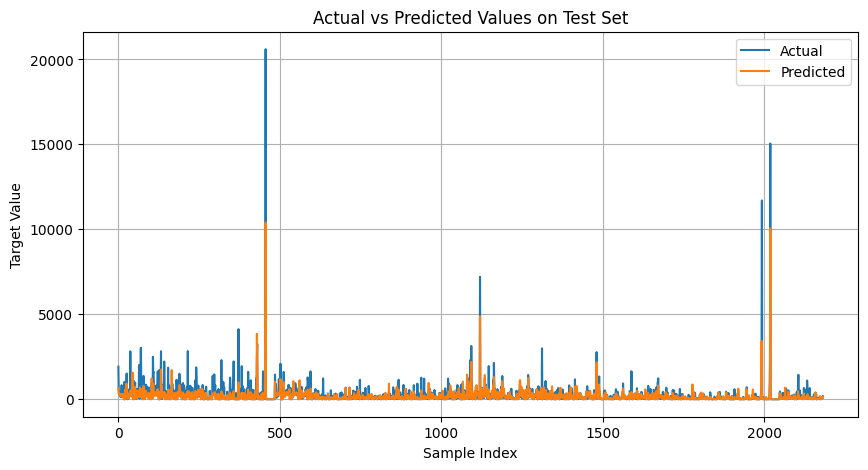

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label="Actual")   # Add markers to see points clearly
plt.plot(y_pred, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("Actual vs Predicted Values on Test Set")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Total number of values
total_values = y_test_real.size
print("Total number of values:", total_values)

# Count zeros
num_zeros = np.sum(y_test_real == 0)
print("Number of zeros:", num_zeros)

# Optional: count all unique values
unique, counts = np.unique(y_test_real, return_counts=True)
for val, count in zip(unique, counts):
    print(f"Value {val}: {count} times")


Total number of values: 2183
Number of zeros: 437
Value 0.0: 437 times
Value 0.9580000000000001: 1 times
Value 1.061: 3 times
Value 1.062: 2 times
Value 1.063: 1 times
Value 1.167: 1 times
Value 1.168: 1 times
Value 1.274: 1 times
Value 1.379: 5 times
Value 1.3799999999999997: 1 times
Value 1.4850000000000003: 1 times
Value 1.4860000000000002: 1 times
Value 1.5909999999999997: 1 times
Value 1.5939999999999999: 1 times
Value 1.7000000000000002: 1 times
Value 1.8039999999999998: 1 times
Value 1.9099999999999997: 1 times
Value 2.021: 1 times
Value 2.1240000000000006: 1 times
Value 2.126: 1 times
Value 2.21: 1 times
Value 2.229: 1 times
Value 2.335: 1 times
Value 2.4410000000000003: 1 times
Value 2.5460000000000003: 1 times
Value 2.5490000000000004: 1 times
Value 2.6539999999999995: 1 times
Value 2.762: 1 times
Value 2.867: 1 times
Value 3.0779999999999994: 1 times
Value 3.2959999999999994: 1 times
Value 3.399: 1 times
Value 3.5029999999999997: 1 times
Value 3.508: 1 times
Value 3.61600000